In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../')
import dataset_wrapper as util

In [4]:
import pandas as pd
m = pd.read_csv(f'/data2/hkaman/Data/FoundationModel/Inputs/Fresno/InD/{2022}/yield_{2022}.csv')
crop_names = m['key_crop_name'].unique().tolist()

In [6]:
output_vector = util.ModelProcessedDataModified(
    county_name = 'Fresno', 
    year = 2013, 
    crop_names = ['Broccoli'])(output_type = "climate_data", 
                                    daily_climate = True)

Broccoli | 129825
Skipping Broccoli due to missing data


In [ ]:
print(output_vector['Winter Wheat']['landsat_data'].shape,
output_vector['Winter Wheat']['et_data'].shape, 
output_vector['Winter Wheat']['climate_data'].shape, 
output_vector['Winter Wheat']['soil_data'].shape)

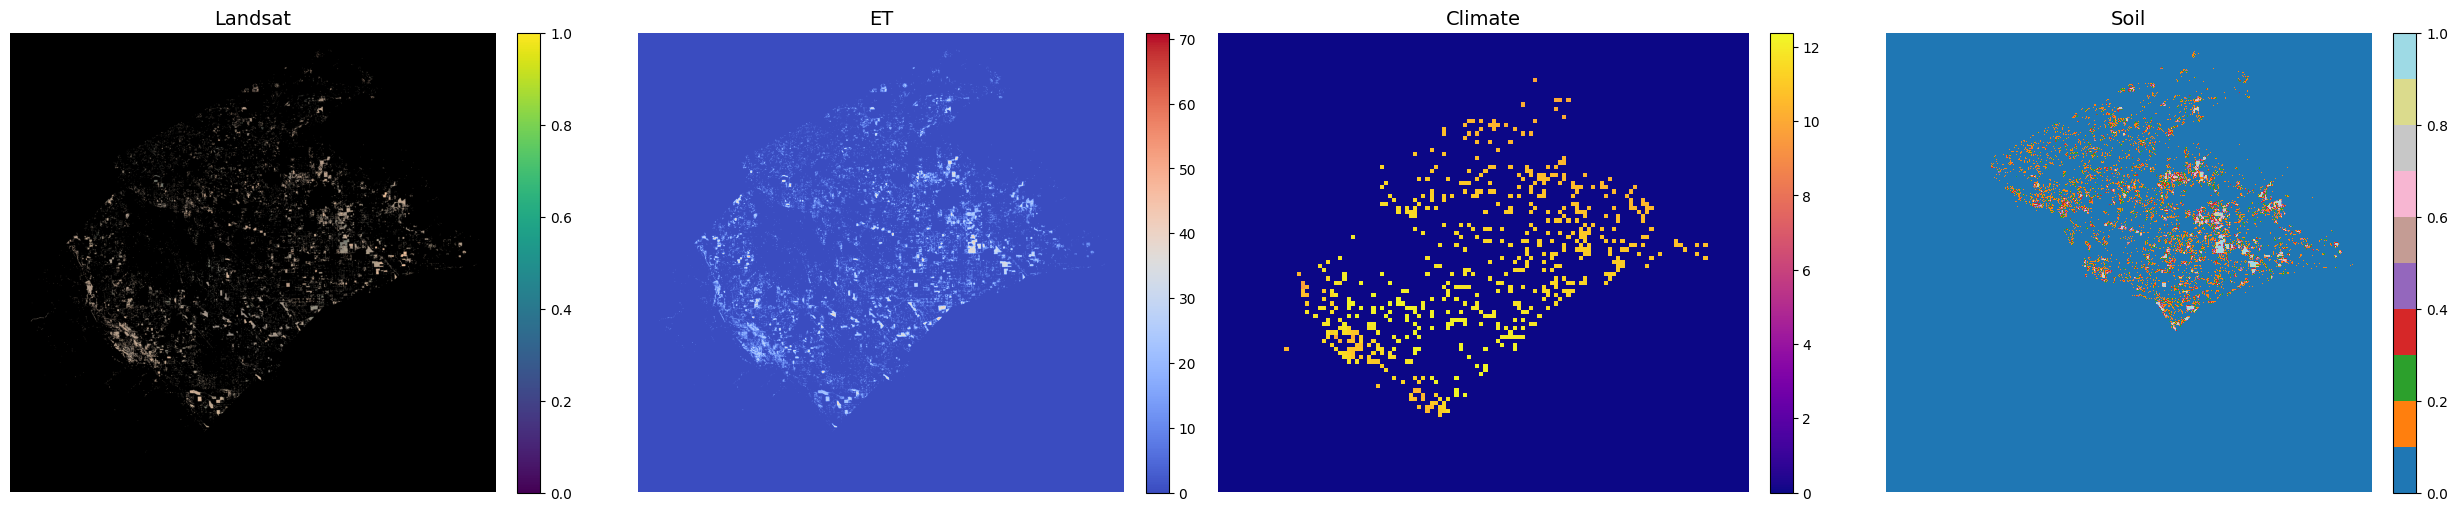

In [8]:
util.plot_datasets(output_vector['Winter Wheat']['landsat_data'][5, :3, ...], 
                   output_vector['Winter Wheat']['et_data'][0, 0, ...], 
                   output_vector['Winter Wheat']['climate_data'][0, 1, ...], 
                   output_vector['Winter Wheat']['soil_data'][2, ...])

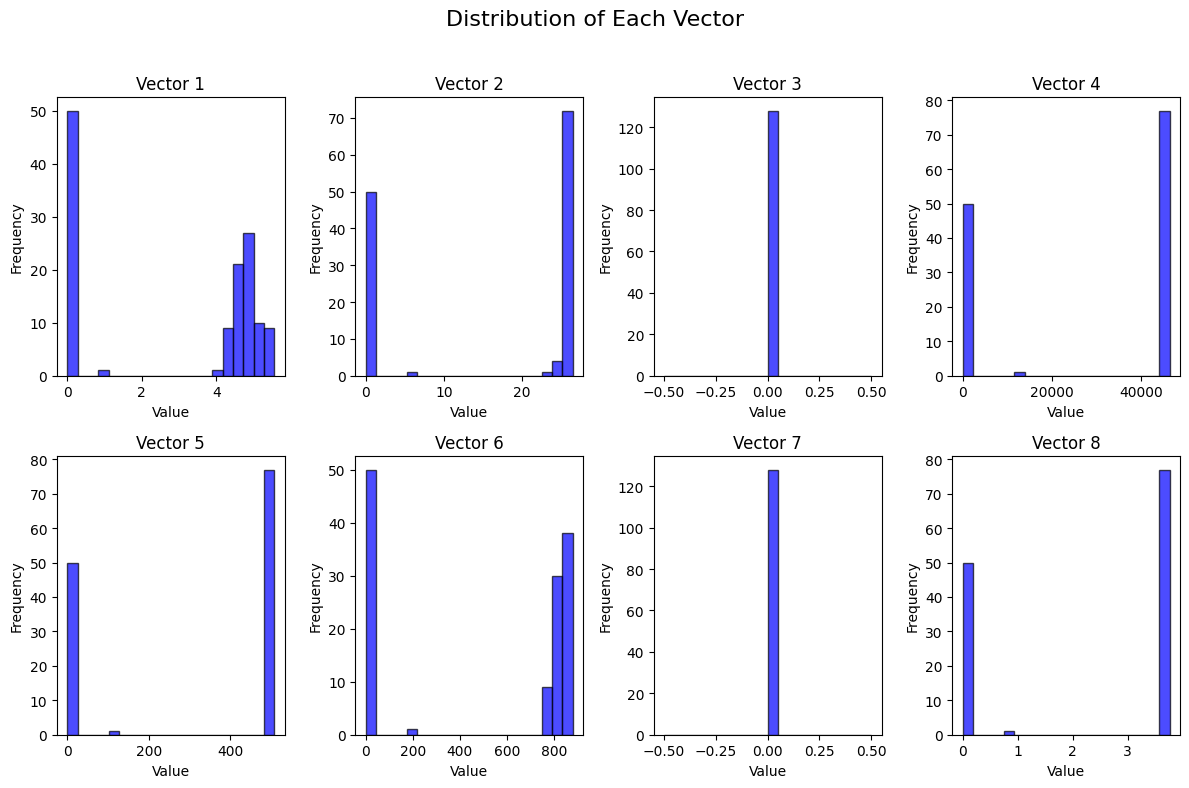

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Generate a 6x128 matrix with random values
matrix = output_vector['Winter Wheat']['climate_data'][100]

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle("Distribution of Each Vector", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each vector's distribution
for i in range(8):
    axes[i].hist(matrix[i], bins=20, alpha=0.7, color="blue", edgecolor="black")
    axes[i].set_title(f"Vector {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Prevent title from overlapping
plt.show()

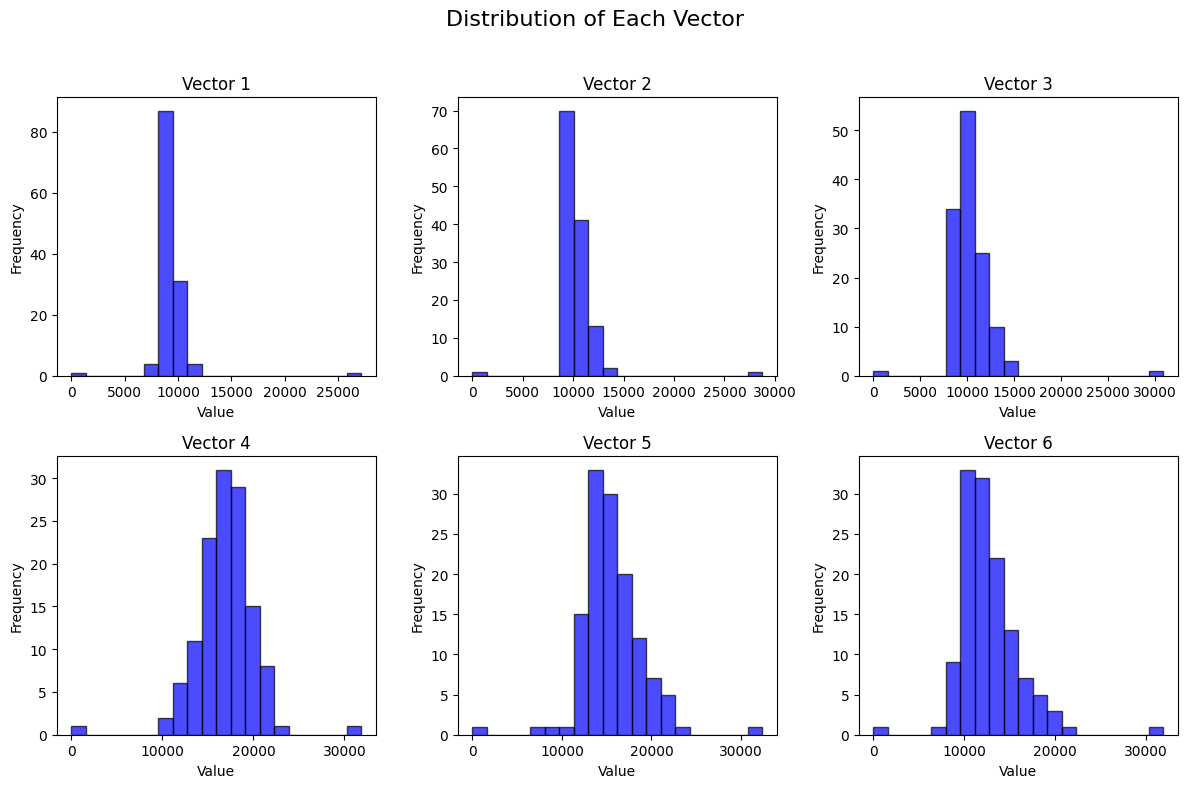

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Generate a 6x128 matrix with random values
matrix = output_vector['Winter Wheat']['et_data'][0]

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Distribution of Each Vector", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each vector's distribution
for i in range(6):
    axes[i].hist(matrix[i], bins=20, alpha=0.7, color="blue", edgecolor="black")
    axes[i].set_title(f"Vector {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Prevent title from overlapping
plt.show()

In [18]:
output_dataset = util.CountyDataCreator(
    county_name = 'Yolo', 
    year = 2008, 
    crop_names= ['Winter Wheat'])(output_type = "landsat_data", 
                                    daily_climate = True)

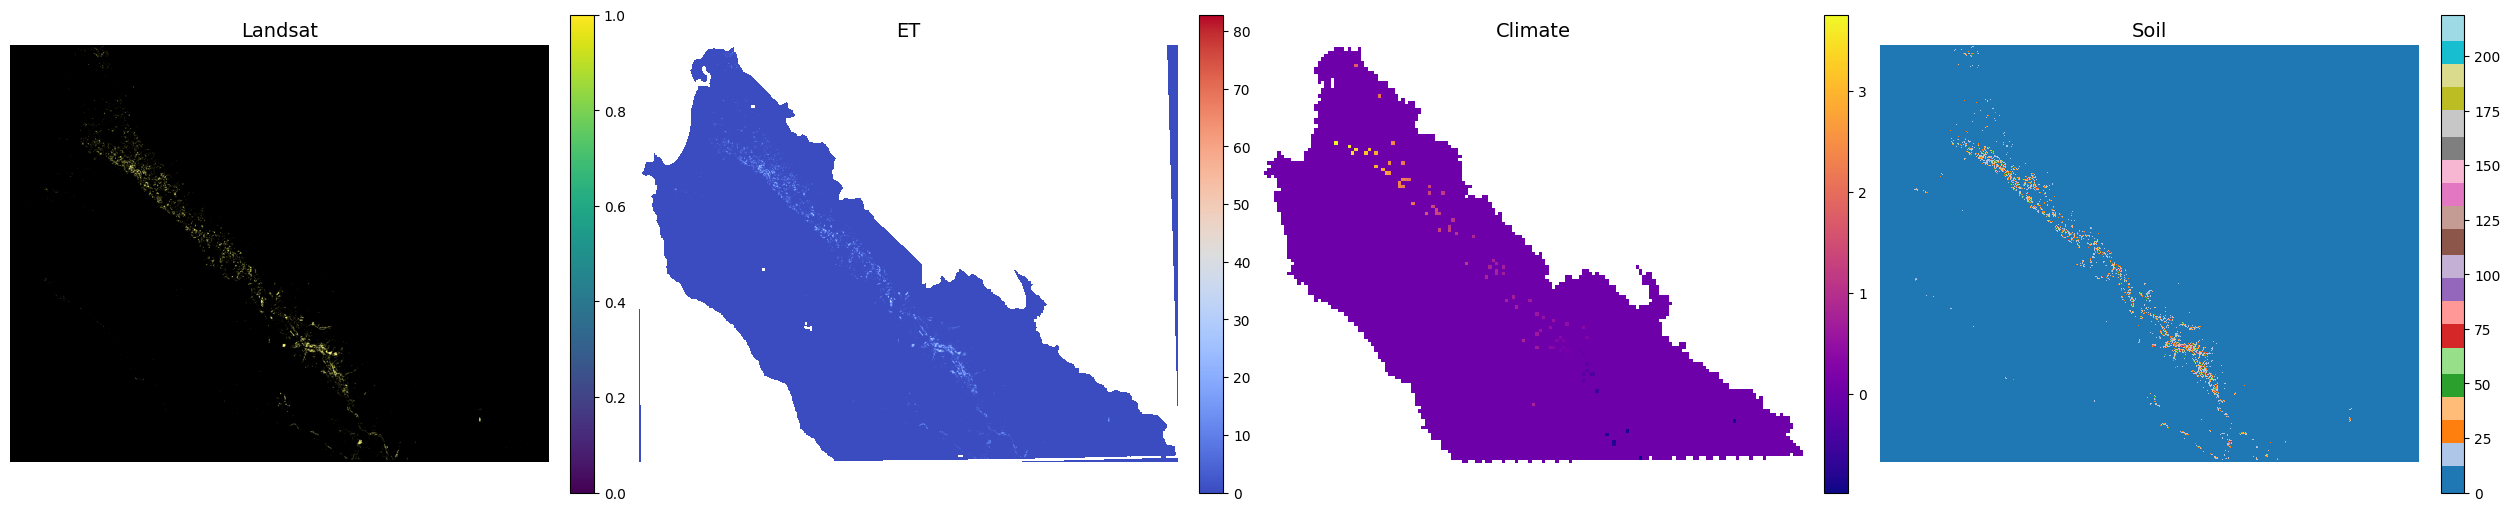

In [ ]:
ccdc.plot_datasets(output_dataset['landsat_data'][5, 0, :3, ...], output_dataset['et_data'][0, 0, 0, ...], output_dataset['climate_data'][0, 1, ...], output_dataset['soil_data'][0, ...])

In [11]:
import os
import rasterio

# Define channel indices for RGB, NIR, SWIR1, and SWIR2 for Landsat 5, 7, and 8
channel_indices = {
    "Landsat5": [1, 2, 3, 4, 5, 7],  # Band 1: Blue, Band 2: Green, Band 3: Red, Band 4: NIR, Band 5: SWIR1, Band 7: SWIR2
    "Landsat7": [1, 2, 3, 4, 5, 7],  # Same as Landsat 5
    "Landsat8": [2, 3, 4, 5, 6, 7],  # Band 2: Blue, Band 3: Green, Band 4: Red, Band 5: NIR, Band 6: SWIR1, Band 7: SWIR2
}

def process_tiff_files(base_folder):
    for year_folder in os.listdir(base_folder):
        if year_folder.isdigit() and 2008 <= int(year_folder) <= 2023:  # Only process folders for the year range
            year_folder_path = os.path.join(base_folder, year_folder)
            if os.path.isdir(year_folder_path):
                for file_name in os.listdir(year_folder_path):
                    if file_name.endswith(".tif"):
                        file_path = os.path.join(year_folder_path, file_name)
                        
                        # Extract the year from the file name (not folder)
                        year = extract_year_from_file_name(file_name)
                        
                        if year is not None and 2008 <= year <= 2023:
                            # Determine Landsat satellite
                            if year <= 2012:
                                satellite = "Landsat5"
                            elif year <= 2013:
                                satellite = "Landsat7"
                            else:
                                satellite = "Landsat8"
                            
                            with rasterio.open(file_path) as src:
                                num_channels = src.count
                                if num_channels > 6:
                                    selected_indices = channel_indices[satellite]
                                    selected_bands = src.read(selected_indices)
                                    
                                    # Save the selected bands to a new file
                                    output_folder = os.path.join(base_folder, "processed", year_folder)
                                    os.makedirs(output_folder, exist_ok=True)
                                    output_path = os.path.join(output_folder, f"processed_{file_name}")
                                    
                                    profile = src.profile
                                    profile.update(count=len(selected_indices))
                                    
                                    with rasterio.open(output_path, "w", **profile) as dst:
                                        dst.write(selected_bands)
                                    
                                    print(f"Processed {file_name}: {satellite} -> {output_path}")

def extract_year_from_file_name(file_name):
    # Example filename: Monterey_LT_20080207
    # Extract the year (4th component) from the filename format
    parts = file_name.split("_")
    if len(parts) > 2:
        try:
            date_str = parts[-1]
            year = int(date_str[:4])  # First 4 digits are the year
            return year
        except ValueError:
            return None
    return None

# Specify the base folder containing year-based folders
base_folder = "/data2/hkaman/Data/FoundationModel/Monterey/Landsat"
process_tiff_files(base_folder)

Processed Monterey_LT_20110404.tif: Landsat5 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/processed/2011/processed_Monterey_LT_20110404.tif
Processed Monterey_LT_20111102.tif: Landsat5 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/processed/2011/processed_Monterey_LT_20111102.tif
Processed Monterey_LT_20110506.tif: Landsat5 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/processed/2011/processed_Monterey_LT_20110506.tif
Processed Monterey_LT_20110607.tif: Landsat5 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/processed/2011/processed_Monterey_LT_20110607.tif
Processed Monterey_LT_20111013.tif: Landsat5 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/processed/2011/processed_Monterey_LT_20111013.tif
Processed Monterey_LT_20110927.tif: Landsat5 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/processed/2011/processed_Monterey_LT_20110927.tif
Processed Monterey_LT_20181203.tif: Landsat8 -> /data2/hkaman/Data/FoundationModel/Monterey/Landsat/

In [4]:
out = util.modify_crop_attr_df(county_name = 'Kings')
out

,aws0100wta,slopegraddcp,awmmfpwwta,drclassdcd,hydgrpdcd,mukey
0,7.64,1.0,1.00,Poorly drained,C/D,461762
1,17.42,3.0,0.50,Well drained,C,461763
2,7.44,1.0,1.00,Poorly drained,B,2218231
3,14.36,1.0,0.62,Somewhat poorly drained,C,2218232
4,10.20,1.0,1.00,Well drained,C,2218233
...,...,...,...,...,...,...
101,4.25,13.0,1.00,Well drained,D,461768
102,11.00,23.0,1.00,Somewhat excessively drained,A,461767
103,11.00,10.0,0.45,Somewhat excessively drained,A,461766
104,8.84,1.0,1.00,Somewhat excessively drained,A,461765


In [ ]:
import os
import re

# Define the parent directory where the subfolders (2008-2022) are located
parent_dir = "/data2/hkaman/Data/FoundationModel/Inputs/LosAngeles/Raw/Landsat"

# Loop through years 2008 to 2022, excluding 2012
for year in range(2017, 2023):
    if year == 2012:
        continue  # Skip 2012

    folder_path = os.path.join(parent_dir, str(year))

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Skipping missing folder: {folder_path}")
        continue

    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        # Match files with the pattern "Landsat_Mosaic_Yolo_YYYY-MM-DD_YYYY-MM-DD.tif"
        # match = re.match(r"Fresno_(\d{4})-(\d{2})-(\d{2})_*.tif", filename)

        match = re.match(r"LA_(\d{4})-(\d{2})-(\d{2}).tif$", filename)

        
        if match:
            # Extract year, month, and day from the first date

            file_year, file_month, file_day = match.groups()
            
            # Construct the new filename
            new_filename = f"LosAngeles_{file_year}_{file_month}_{file_day}.tif"
            
            # Define full paths
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)

            # Rename the file
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} → {new_filename}")

print("Renaming completed.")

In [ ]:
for year in range(2009, 2023):
    if year != 2012:
        modified = {}
        npz_file_path = f'/data2/hkaman/Data/FoundationModel/Inputs/Monterey/InD/{year}/Monterey_{year}.npz'
        loaded_data = np.load(npz_file_path, allow_pickle=True)["input"].item()
        crop_names =list(loaded_data.keys())
        for crop_name in loaded_data.keys():
            crop_output = {}
            landsat = loaded_data[crop_name]['landsat_data']
            et = loaded_data[crop_name]['et_data']
            climate = loaded_data[crop_name]['climate_data']
            soil = loaded_data[crop_name]['soil_data']

            print(crop_name)
            print(landsat.shape, et.shape, climate.shape, soil.shape)
            if landsat.shape[-1] != 0 and et.shape[-1] != 0 and climate.shape[-1] != 0 and soil.shape[-1] != 0: 
                landsat_str = util.stratified_sampling(landsat, num_samples=128)
                et_str = util.stratified_sampling(et, num_samples=128)
                climate_str = util.stratified_sampling(climate, num_samples=128)
                soil_str = util.stratified_sampling(soil, num_samples=128)
                print(landsat_str.shape, et_str.shape, climate_str.shape, soil_str.shape)
                print()
                crop_output['landsat_data'] = landsat_str
                crop_output['et_data'] = et_str
                crop_output['climate_data'] = climate_str
                crop_output['soil_data'] = soil_str

                modified[crop_name] = crop_output

        import numpy
        npz_file_path_modified = f'/data2/hkaman/Data/FoundationModel/Inputs/Monterey/InD/{year}/Monterey_{year}_modified.npz'
        numpy.savez_compressed(npz_file_path_modified, inumpyut = modified)

In [3]:
import os
import re
from pathlib import Path

def rename_geospatial_files(parent_folder):
    for county_dir in Path(parent_folder).iterdir():
        if not county_dir.is_dir():
            continue
        
        raw_path = county_dir / 'Raw'
        if not raw_path.exists():
            continue

        # Process CDL
        cdl_path = raw_path / 'CDL'
        if cdl_path.exists():
            for year_folder in cdl_path.iterdir():
                if not year_folder.name.isdigit() or year_folder.name == "2012":
                    continue
                for tif_file in year_folder.glob('*.tif'):
                    expected_name = f"{county_dir.name}_CDL_{year_folder.name}.tif"
                    if tif_file.name != expected_name:
                        tif_file.rename(tif_file.parent / expected_name)

        # Process Climate
        climate_path = raw_path / 'Climate'
        if climate_path.exists():
            for year_folder in climate_path.iterdir():
                if not year_folder.name.isdigit() or year_folder.name == "2012":
                    continue
                for nc_file in year_folder.glob('*.nc'):
                    expected_name = f"{county_dir.name}_DayMet_{year_folder.name}.nc"
                    if nc_file.name != expected_name:
                        nc_file.rename(nc_file.parent / expected_name)

        # Process ET
        et_path = raw_path / 'ET'
        if et_path.exists():
            for year_folder in et_path.iterdir():
                if not year_folder.name.isdigit() or year_folder.name == "2012":
                    continue
                for file in year_folder.glob('*.tif'):
                    pattern = re.compile(rf"{county_dir.name}_OpenET_\d{{4}}_\d{{2}}\.tif")
                    if not pattern.match(file.name):
                        parts = file.stem.split('_')
                        if len(parts) >= 4:
                            year, month = parts[-2], parts[-1]
                            new_name = f"{county_dir.name}_OpenET_{year}_{month}.tif"
                            file.rename(file.parent / new_name)

        # Process Landsat
        landsat_path = raw_path / 'Landsat'
        if landsat_path.exists():
            for year_folder in landsat_path.iterdir():
                if not year_folder.name.isdigit() or year_folder.name == "2012":
                    continue
                for file in year_folder.glob('*.tif'):
                    match = re.match(rf"{county_dir.name}_(\d{{4}})_(\d{{2}})_\d{{2}}\.tif", file.name)
                    if match:
                        year, month = match.group(1), match.group(2)
                        new_name = f"{county_dir.name}_LT_{year}_{month}.tif"
                        file.rename(file.parent / new_name)

# Example usage:
rename_geospatial_files('/data2/hkaman/Data/YieldBenchmark/counties')

In [21]:

def rename_landsat_files(county_new_name, county_old_name):
    landsat_path = Path('/data2/hkaman/Data/YieldBenchmark/counties') / county_new_name / 'Raw' / 'Landsat'

    if not landsat_path.exists():
        print(f"Path does not exist: {landsat_path}")
        return

    # Assuming county_old_name might be like "OldName_CA" or similar
    parts = county_old_name.replace(".tif", "").split("_")

    for year_folder in landsat_path.iterdir():
        if not year_folder.is_dir() or not year_folder.name.isdigit() or year_folder.name == "2012":
            continue

        for file in year_folder.glob('*.tif'):
            match = re.match(rf"{parts[0]}_{parts[1]}_LT_(\d{{4}})_(\d{{2}})\.tif", file.name)
            if match:
                year, month = match.group(1), match.group(2)
                new_name = f"{county_new_name}_LT_{year}_{month}.tif"
                new_file_path = file.parent / new_name
                print(f"Renaming: {file.name} -> {new_name}")
                file.rename(new_file_path)

In [ ]:
rename_landsat_files(county_new_name = 'SanJoaquin', county_old_name = 'San_Joaquin')

In [23]:
def rename_et_folders(county_name):
    et_path = Path('/data2/hkaman/Data/YieldBenchmark/counties') / county_name / 'Raw' / 'ET'

    if not et_path.exists():
        print(f"Path does not exist: {et_path}")
        return

    for folder in list(et_path.iterdir()):
        if not folder.is_dir():
            continue

        # If folder is already just a 4-digit year (and not 2012), skip
        if folder.name.isdigit():
            if folder.name == "2012":
                continue
            continue

        # Match format: OpenET_{county_name}_{year}
        match = re.match(rf"OpenET_{county_name}_(\d{{4}})", folder.name)
        if match:
            year = match.group(1)
            if year == "2012":
                continue
            new_folder = et_path / year
            print(f"Renaming folder: {folder.name} -> {year}")
            folder.rename(new_folder)


In [26]:
import os
county_names = sorted(list(os.listdir('/data2/hkaman/Data/YieldBenchmark/counties')))

for n in county_names:
    rename_et_folders(county_name = n)

Renaming folder: OpenET_Mariposa_2011 -> 2011
Renaming folder: OpenET_Mariposa_2020 -> 2020
Renaming folder: OpenET_Mariposa_2021 -> 2021
Renaming folder: OpenET_Mariposa_2018 -> 2018
Renaming folder: OpenET_Mariposa_2016 -> 2016
Renaming folder: OpenET_Mariposa_2015 -> 2015
Renaming folder: OpenET_Mariposa_2008 -> 2008
Renaming folder: OpenET_Mariposa_2010 -> 2010
Renaming folder: OpenET_Mariposa_2019 -> 2019
Renaming folder: OpenET_Mariposa_2022 -> 2022
Renaming folder: OpenET_Mariposa_2017 -> 2017
Renaming folder: OpenET_Mariposa_2009 -> 2009
Renaming folder: OpenET_Mariposa_2013 -> 2013
Renaming folder: OpenET_Mariposa_2014 -> 2014
Renaming folder: OpenET_Sacramento_2019 -> 2019
Renaming folder: OpenET_Sacramento_2020 -> 2020
Renaming folder: OpenET_Sacramento_2011 -> 2011
Renaming folder: OpenET_Sacramento_2017 -> 2017
Renaming folder: OpenET_Sacramento_2018 -> 2018
Renaming folder: OpenET_Sacramento_2013 -> 2013
Renaming folder: OpenET_Sacramento_2008 -> 2008
Renaming folder: Ope